<a href="https://colab.research.google.com/github/Jatinnagar777/demo/blob/main/Wine_review_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [84]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [85]:
df.dropna(subset=['description', 'points'], inplace=True)

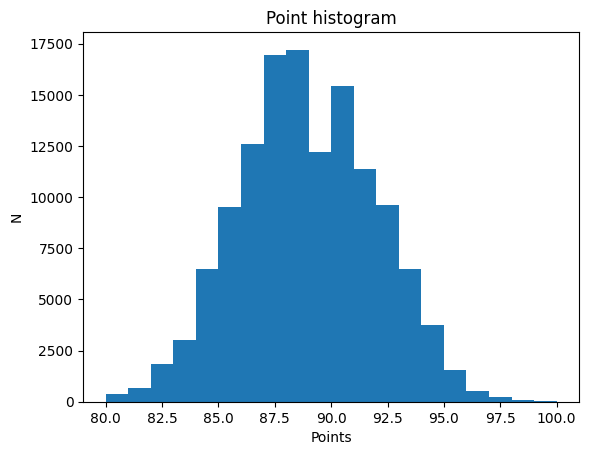

In [86]:
plt.hist(df.points, bins=20)
plt.title('Point histogram')
plt.xlabel('Points')
plt.ylabel('N')
plt.show()

In [87]:
df['label'] = (df.points>=90).astype(int)
df = df[['description', 'label']]

In [88]:
train, valid, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [89]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [90]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

#Embedding + Model

In [91]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype = tf.string, trainable=True)

In [92]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.52906865, -0.10256412,  0.16662206, ..., -0.01481339,
        -0.18137392,  0.20526922],
       [ 0.29726472, -0.25786495,  0.138871  , ..., -0.03101487,
        -0.3626828 ,  0.06161248],
       [ 0.53365624, -0.415085  , -0.1544177 , ...,  0.07416819,
        -0.19506215,  0.35420215],
       ...,
       [ 0.28771985, -0.2005809 ,  0.11570213, ..., -0.03077759,
        -0.09668299, -0.21788895],
       [ 0.46195224, -0.50298405, -0.03774641, ..., -0.02608037,
        -0.18718672, -0.10292795],
       [ 0.24803188, -0.3023421 , -0.09767412, ..., -0.19604264,
        -0.10455641,  0.16415648]], dtype=float32)>

In [93]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [94]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [95]:
model.evaluate(train_data)

102/102 [==============================] - 1s 9ms/step - loss: 0.7101 - accuracy: 0.3951


[0.7100734114646912, 0.3951200246810913]

In [96]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 8ms/step - loss: 0.7103 - accuracy: 0.3941


[0.7102879881858826, 0.3940909504890442]

In [97]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 106s 1s/step - loss: 0.6223 - accuracy: 0.6512 - val_loss: 0.4891 - val_accuracy: 0.7841
Epoch 2/5
102/102 [==============================] - 105s 1s/step - loss: 0.4645 - accuracy: 0.7847 - val_loss: 0.3989 - val_accuracy: 0.8163
Epoch 3/5
102/102 [==============================] - 106s 1s/step - loss: 0.3970 - accuracy: 0.8275 - val_loss: 0.3764 - val_accuracy: 0.8256
Epoch 4/5
102/102 [==============================] - 105s 1s/step - loss: 0.3612 - accuracy: 0.8448 - val_loss: 0.3718 - val_accuracy: 0.8290
Epoch 5/5
102/102 [==============================] - 106s 1s/step - loss: 0.3374 - accuracy: 0.8575 - val_loss: 0.3725 - val_accuracy: 0.8328


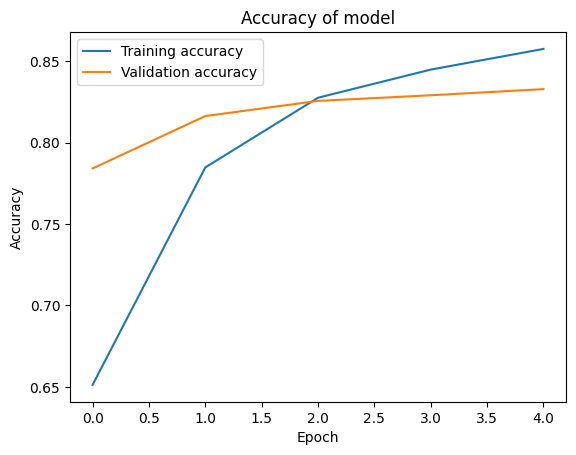

In [98]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy of model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

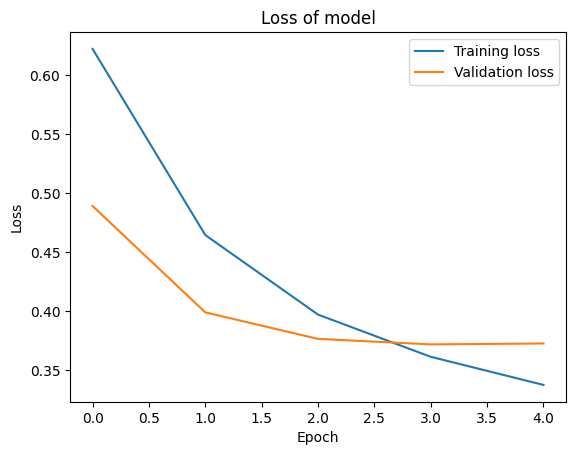

In [99]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [100]:
model.evaluate(test_data)

13/13 [==============================] - 3s 260ms/step - loss: 0.3746 - accuracy: 0.8289


[0.37460002303123474, 0.8288967609405518]

#LSTM

In [101]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [102]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [103]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [104]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [105]:
model.evaluate(train_data)

102/102 [==============================] - 26s 206ms/step - loss: 0.6934 - accuracy: 0.4645


[0.6934155225753784, 0.46450141072273254]

In [107]:
model.evaluate(valid_data)

13/13 [==============================] - 3s 240ms/step - loss: 0.6934 - accuracy: 0.4577


[0.6934479475021362, 0.4577210247516632]

In [108]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 46s 396ms/step - loss: 0.5256 - accuracy: 0.7285 - val_loss: 0.3679 - val_accuracy: 0.8323
Epoch 2/5
102/102 [==============================] - 41s 397ms/step - loss: 0.3672 - accuracy: 0.8369 - val_loss: 0.3501 - val_accuracy: 0.8372
Epoch 3/5
102/102 [==============================] - 40s 396ms/step - loss: 0.3496 - accuracy: 0.8448 - val_loss: 0.3442 - val_accuracy: 0.8404
Epoch 4/5
102/102 [==============================] - 40s 392ms/step - loss: 0.3421 - accuracy: 0.8486 - val_loss: 0.3440 - val_accuracy: 0.8415
Epoch 5/5
102/102 [==============================] - 40s 393ms/step - loss: 0.3389 - accuracy: 0.8504 - val_loss: 0.3430 - val_accuracy: 0.8426


In [109]:
model.evaluate(test_data)

13/13 [==============================] - 4s 295ms/step - loss: 0.3464 - accuracy: 0.8417


[0.3464002013206482, 0.8416679501533508]